# Earthquake Prediction


##Importing Libraries

In [6]:
import pandas as pd
import numpy as np
from google.colab import data_table
import matplotlib.pyplot as plt
!pip install cartopy
import cartopy.crs as ccrs
import seaborn as sns

##Importing dataset

In [7]:
data_table.enable_dataframe_formatter()

df_raw = pd.read_csv('earthquake_1995-2023.csv')

display(df_raw.head())
display(df_raw.shape)

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,16-08-2023 12:47,7,4,green,0,657,us,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",NaN,Vanuatu
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,19-07-2023 00:22,8,6,yellow,0,775,us,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,"Intipucá, El Salvador",NaN,NaN
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,17-07-2023 03:05,7,5,green,0,899,us,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,"Loncopué, Argentina",South America,Argentina
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,16-07-2023 06:48,6,6,green,1,860,us,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,"Sand Point, Alaska",NaN,NaN
4,M 7.3 - Alaska Peninsula,7.3,16-07-2023 06:48,0,5,NaN,1,820,at,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,Alaska Peninsula,NaN,NaN


(1000, 19)

In [8]:
print(df_raw.columns)


Index(['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami',
       'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude',
       'longitude', 'location', 'continent', 'country'],
      dtype='object')


###Visualization of data

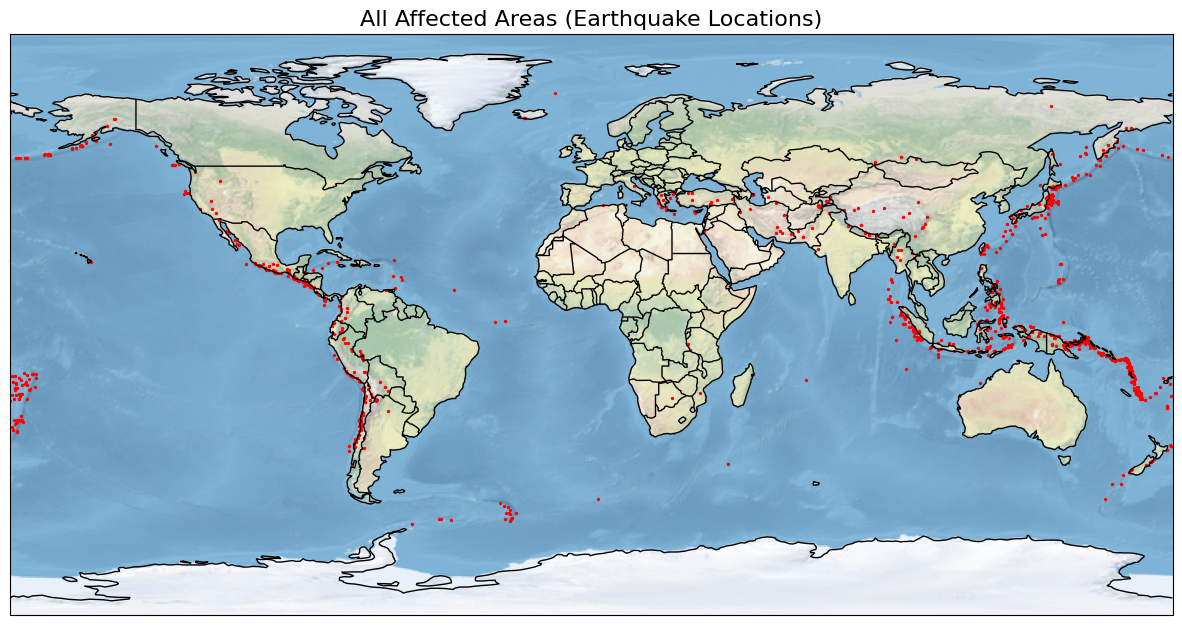

In [9]:
plt.figure(figsize=(15,10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

ax.coastlines()
ax.stock_img()
ax.add_feature(__import__("cartopy").feature.BORDERS)

plt.scatter(df_raw['longitude'], df_raw['latitude'],s=2, color='red',
    transform=ccrs.PlateCarree()
)

plt.title("All Affected Areas (Earthquake Locations)", fontsize=16)
plt.show()


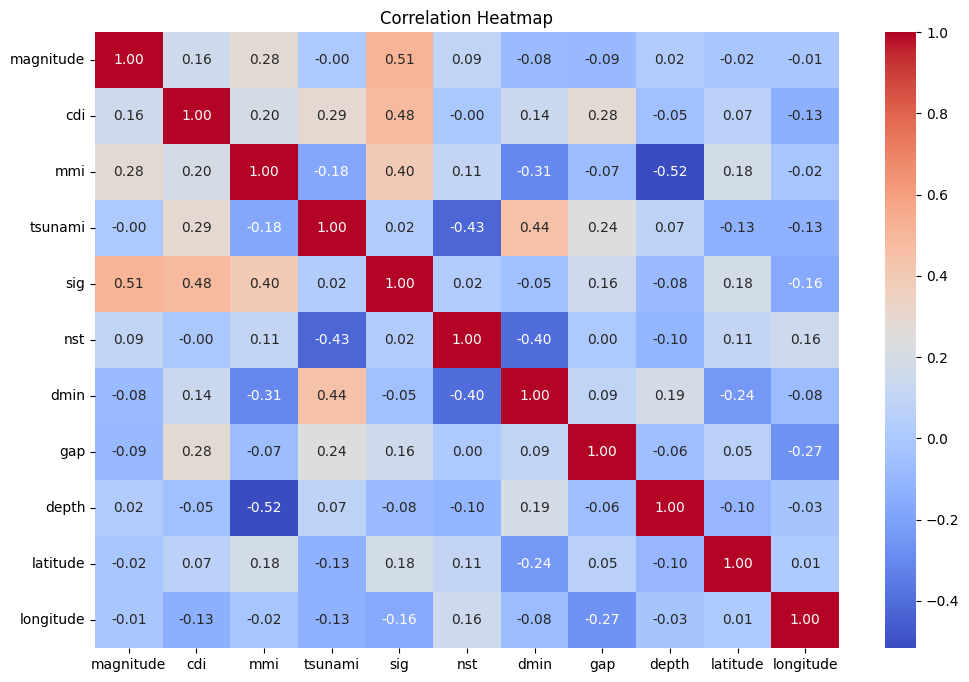

In [10]:
#Correlation HEATMAP
# Pick only the numeric columns and find how they relate
corr = df_raw.select_dtypes(include='number').corr()

# Draw the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


##Preprocessing & Spliting


###Shows information about your dataset, Creates a safe copy to work on

In [11]:
print('Columns:', list(df_raw.columns))
print('\nDtypes:\n', df_raw.dtypes)
print('\nMissing values per column:\n', df_raw.isna().sum())

df = df_raw.copy()


Columns: ['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami', 'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude', 'longitude', 'location', 'continent', 'country']

Dtypes:
 title         object
magnitude    float64
date_time     object
cdi            int64
mmi            int64
alert         object
tsunami        int64
sig            int64
net           object
nst            int64
dmin         float64
gap          float64
magType       object
depth        float64
latitude     float64
longitude    float64
location      object
continent     object
country       object
dtype: object

Missing values per column:
 title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        551
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       6
continent    716
country      349
dtype: int64


In [12]:
# clean and standardize column names – only rename what exists in your dataset
col_map = {
    'mag': 'magnitude',
    'magnitude': 'magnitude',
    'date_time': 'date_time',
    'time': 'time',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'depth': 'depth',
    'magType': 'magType',
    'nst': 'num_stations',
    'dmin': 'dmin',
    'gap': 'gap',
    'rms': 'rms',
    'mmi': 'mmi',
    'cdi': 'cdi',
    'alert': 'alert',
    'tsunami': 'tsunami',
    'country': 'country',
    'continent': 'continent',
    'location': 'location',
    'title': 'title',
    'sig': 'sig'
}

# Apply renaming only to matching columns
df = df.rename(columns={c: col_map[c] for c in df.columns if c in col_map})

print("Renamed columns:")
print(df.columns.tolist())


Renamed columns:
['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami', 'sig', 'net', 'num_stations', 'dmin', 'gap', 'magType', 'depth', 'latitude', 'longitude', 'location', 'continent', 'country']


In [13]:
# Parse datetime column
if 'date_time' in df.columns:
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    print("\nInvalid datetime rows:", df['date_time'].isna().sum())

    df['year'] = df['date_time'].dt.year
    df['month'] = df['date_time'].dt.month
    df['day'] = df['date_time'].dt.day
    df['hour'] = df['date_time'].dt.hour

    df = df.set_index('date_time')



Invalid datetime rows: 0


/tmp/ipython-input-3505017482.py:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')


In [14]:
# Select useful features
feature_list = [
    'latitude','longitude','depth','num_stations','dmin','gap','rms',
    'mmi','cdi','tsunami','sig','year','month','hour',
    'magType','alert','continent','country','location','title'
]

keep_cols = [c for c in feature_list if c in df.columns]
print("Keeping columns:", keep_cols)

df_model = df[keep_cols + ['magnitude']].copy()

df_model = df_model.dropna(subset=['magnitude'])

#missing values handling
num_cols = df_model.select_dtypes(include=['number']).columns.drop('magnitude')
df_model[num_cols] = df_model[num_cols].fillna(df_model[num_cols].median())

cat_cols = df_model.select_dtypes(include=['object']).columns
df_model[cat_cols] = df_model[cat_cols].fillna('missing')

print("Missing values after cleaning:\n", df_model.isna().sum())


Keeping columns: ['latitude', 'longitude', 'depth', 'num_stations', 'dmin', 'gap', 'mmi', 'cdi', 'tsunami', 'sig', 'year', 'month', 'hour', 'magType', 'alert', 'continent', 'country', 'location', 'title']
Missing values after cleaning:
 latitude        0
longitude       0
depth           0
num_stations    0
dmin            0
gap             0
mmi             0
cdi             0
tsunami         0
sig             0
year            0
month           0
hour            0
magType         0
alert           0
continent       0
country         0
location        0
title           0
magnitude       0
dtype: int64


In [15]:
print(df_model['magnitude'].describe())
print("\nRounded magnitude counts:")
print(df_model['magnitude'].round().value_counts().sort_index())

count    1000.000000
mean        6.940150
std         0.438148
min         6.500000
25%         6.600000
50%         6.800000
75%         7.100000
max         9.100000
Name: magnitude, dtype: float64

Rounded magnitude counts:
magnitude
6.0    165
7.0    691
8.0    139
9.0      5
Name: count, dtype: int64


### CORE PREPROCESSING AND SPLITING OF DATASET

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

# Create a 'mag_class' column by rounding the 'magnitude' for classification
df_model['mag_class'] = df_model['magnitude'].round().astype(int)

# Remap 'mag_class' to be 0-indexed for XGBoost
# Get unique sorted classes to create a mapping
unique_classes = sorted(df_model['mag_class'].unique())
class_mapping = {old_val: new_val for new_val, old_val in enumerate(unique_classes)}
df_model['mag_class'] = df_model['mag_class'].map(class_mapping)

# Train-test split (CLASSIFICATION)
X = df_model.drop(columns=['magnitude', 'mag_class'])
y = df_model['mag_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/Test shapes:", X_train.shape, X_test.shape)

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

# Transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

Train/Test shapes: (800, 19) (200, 19)
Numeric: ['latitude', 'longitude', 'depth', 'num_stations', 'dmin', 'gap', 'mmi', 'cdi', 'tsunami', 'sig', 'year', 'month', 'hour']
Categorical: ['magType', 'alert', 'continent', 'country', 'location', 'title']


##LOGISTIC REGRESSION

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logistic Regression Pipeline
lr_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

# Train
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", accuracy_lr)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.71

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.09      0.15        33
           1       0.73      0.93      0.82       138
           2       0.58      0.39      0.47        28
           3       0.00      0.00      0.00         1

    accuracy                           0.71       200
   macro avg       0.45      0.35      0.36       200
weighted avg       0.67      0.71      0.66       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Visualization(Actual Vs Predicted Logistic Reg)

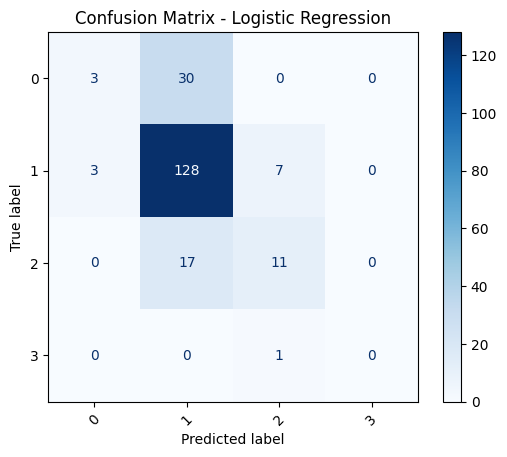

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lr,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - Logistic Regression")
plt.show()


##KNN CLASSIFIER

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# KNN Classifier Pipeline
knn_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

# Train
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Evaluate
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print("KNN Accuracy:", accuracy_knn)
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.15      0.20        33
           1       0.72      0.93      0.81       138
           2       0.67      0.07      0.13        28
           3       0.00      0.00      0.00         1

    accuracy                           0.68       200
   macro avg       0.42      0.29      0.29       200
weighted avg       0.64      0.68      0.61       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Visulaization KNN

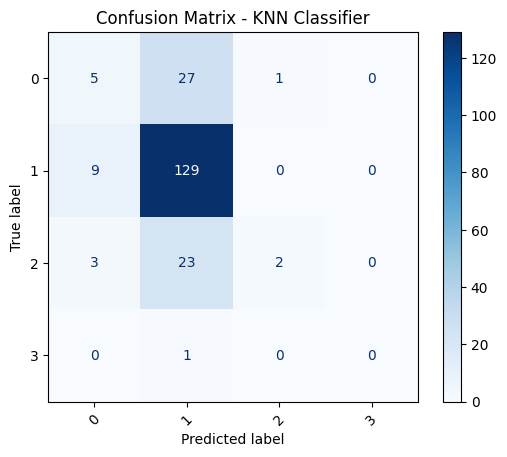

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_knn,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - KNN Classifier")
plt.show()


##NAIVE BAYES CLASSIFIER

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Naive Bayes Pipeline
nb_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', GaussianNB())
])

# Train
nb_model.fit(X_train, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test)

# Evaluate
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print("Naive Bayes Accuracy:", accuracy_nb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.31

Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.21      0.18        33
           1       0.70      0.30      0.42       138
           2       0.13      0.46      0.21        28
           3       0.00      0.00      0.00         1

    accuracy                           0.31       200
   macro avg       0.25      0.25      0.20       200
weighted avg       0.53      0.31      0.35       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###VISUALIZATION NAIVE BAYES CLA

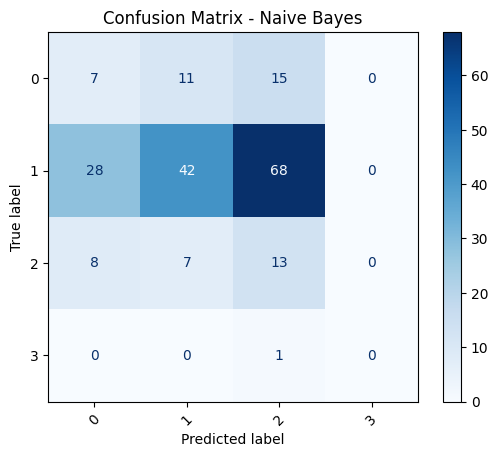

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_nb,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - Naive Bayes")
plt.show()


##ADABOOST CLASSIFIER

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# AdaBoost Classifier Pipeline
ada_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', AdaBoostClassifier(
        n_estimators=200,
        learning_rate=0.5,
        random_state=42
    ))
])

# Train
ada_model.fit(X_train, y_train)

# Predict
y_pred_ada = ada_model.predict(X_test)

# Evaluate
accuracy_ada = accuracy_score(y_test, y_pred_ada)

print("AdaBoost Accuracy:", accuracy_ada)
print("\nClassification Report:\n", classification_report(y_test, y_pred_ada))


AdaBoost Accuracy: 0.795

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.67      0.79        33
           1       0.80      0.96      0.87       138
           2       0.45      0.18      0.26        28
           3       0.00      0.00      0.00         1

    accuracy                           0.80       200
   macro avg       0.55      0.45      0.48       200
weighted avg       0.77      0.80      0.76       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###VISUALIZATION ADABOOST

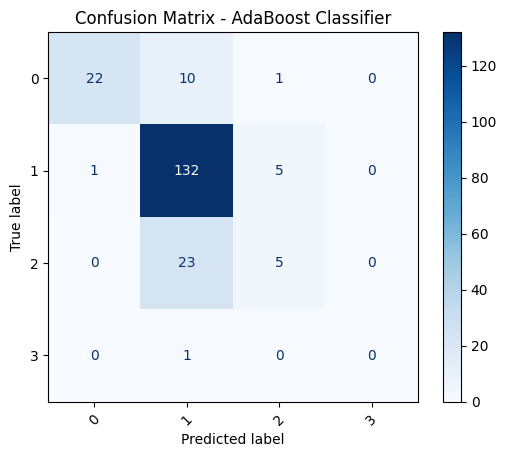

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_ada,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - AdaBoost Classifier")
plt.show()


##GRADIENT BOOSTING CLASSIFIER

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Gradient Boosting Classifier Pipeline
gb_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

# Train
gb_model.fit(X_train, y_train)

# Predict
y_pred_gb = gb_model.predict(X_test)

# Evaluate
accuracy_gb = accuracy_score(y_test, y_pred_gb)

print("Gradient Boosting Accuracy:", accuracy_gb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.885

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80        33
           1       0.88      0.97      0.92       138
           2       0.81      0.75      0.78        28
           3       0.00      0.00      0.00         1

    accuracy                           0.89       200
   macro avg       0.67      0.60      0.63       200
weighted avg       0.89      0.89      0.88       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###VISUALIZATION

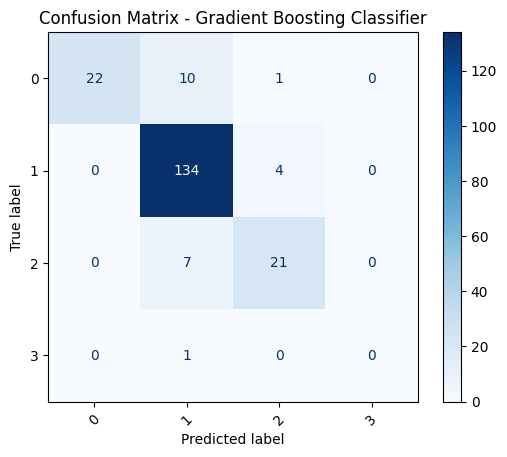

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_gb,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - Gradient Boosting Classifier")
plt.show()


##EXTRA TREES

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Extra Trees Classifier Pipeline
et_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', ExtraTreesClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# Train
et_model.fit(X_train, y_train)

# Predict
y_pred_et = et_model.predict(X_test)

# Evaluate
accuracy_et = accuracy_score(y_test, y_pred_et)

print("Extra Trees Accuracy:", accuracy_et)
print("\nClassification Report:\n", classification_report(y_test, y_pred_et))


Extra Trees Accuracy: 0.71

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.09      0.17        33
           1       0.71      0.99      0.82       138
           2       0.60      0.11      0.18        28
           3       0.00      0.00      0.00         1

    accuracy                           0.71       200
   macro avg       0.58      0.30      0.29       200
weighted avg       0.74      0.71      0.62       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###VISUALIZATION

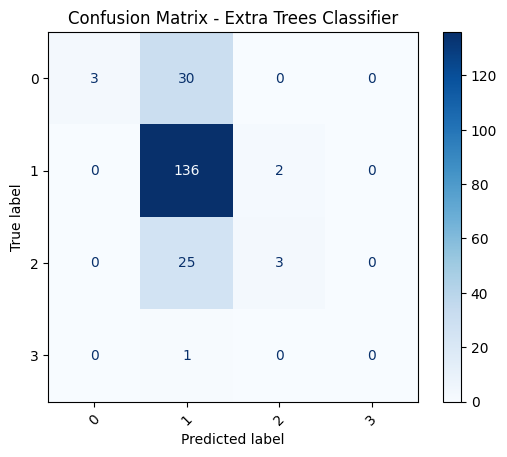

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_et,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - Extra Trees Classifier")
plt.show()


## SVC

In [29]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# SVC Pipeline
svr_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', SVC(kernel='rbf'))
])

# Train
svr_model.fit(X_train, y_train)

# Predict
y_pred_svr = svr_model.predict(X_test)

# Evaluate
accuracy_svr = accuracy_score(y_test, y_pred_svr)

print("SVC Accuracy:", accuracy_svr)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svr))


SVC Accuracy: 0.705

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.71      0.99      0.83       138
           2       0.67      0.14      0.24        28
           3       0.00      0.00      0.00         1

    accuracy                           0.70       200
   macro avg       0.34      0.28      0.27       200
weighted avg       0.58      0.70      0.60       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Visualization(Actual Vs Predicted SVC)

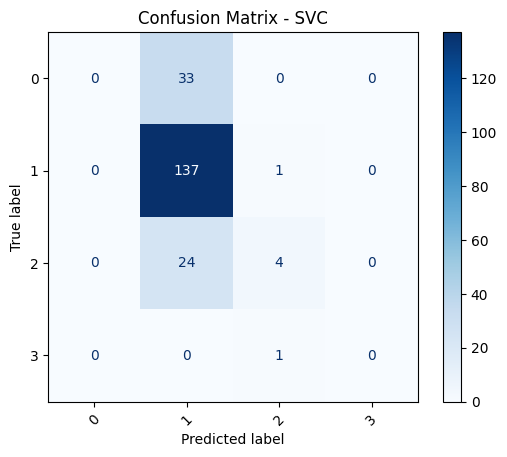

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_svr,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - SVC")
plt.show()


##DECISION TREE CLASSIFIER

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Decision Tree Classifier Pipeline
dt_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

# Train
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

# Evaluate
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print("Decision Tree Accuracy:", accuracy_dt)
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.815

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.70      0.74        33
           1       0.85      0.90      0.87       138
           2       0.64      0.57      0.60        28
           3       0.00      0.00      0.00         1

    accuracy                           0.81       200
   macro avg       0.57      0.54      0.55       200
weighted avg       0.81      0.81      0.81       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###Visualization(Actual Vs Predicted Decision Tree Classifier)

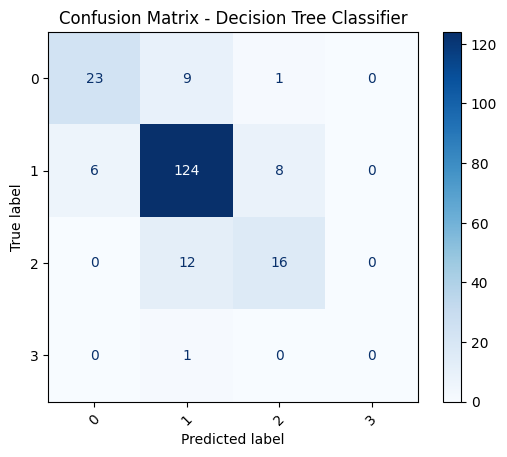

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_dt,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - Decision Tree Classifier")
plt.show()


## RANDOMFOREST CLASSIFIER

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest Classifier pipeline
rf_model = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit model
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7950

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.64      0.78        33
           1       0.77      1.00      0.87       138
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00         1

    accuracy                           0.80       200
   macro avg       0.44      0.41      0.41       200
weighted avg       0.70      0.80      0.73       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualization(Actual vs Predicted RandomForestCla)

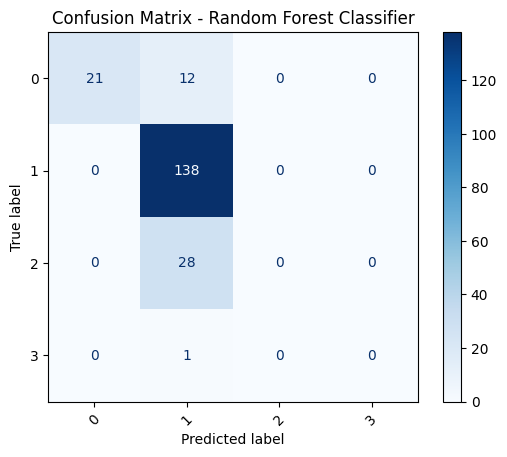

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()


###Top Feature Importances (RandomForest)

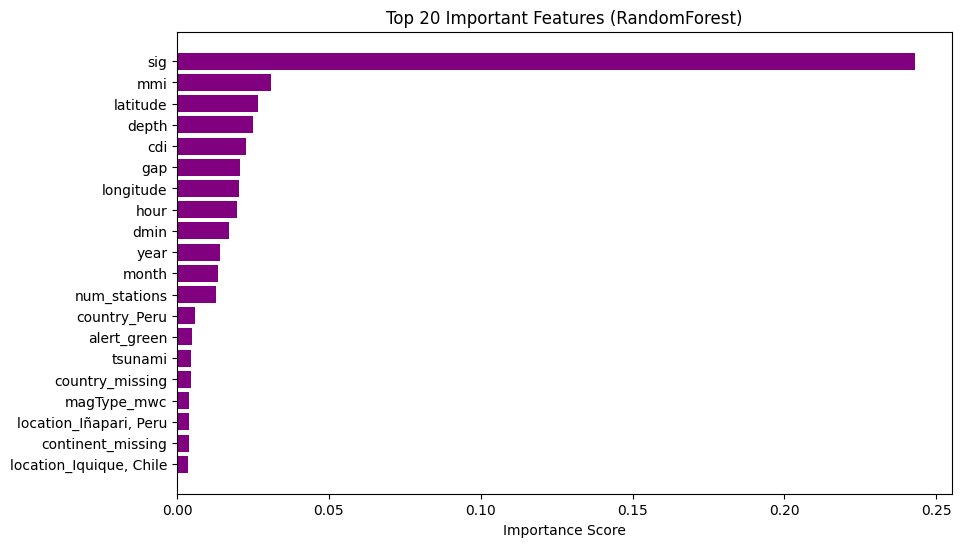

In [35]:
# Extract the trained RandomForest model
rf = rf_model.named_steps["model"]

# Get encoded categorical feature names
ohe = rf_model.named_steps["pre"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()

# Combine with numeric feature names
all_feature_names = numeric_features + cat_feature_names

# Create importance dataframe
importances = pd.DataFrame({
    "feature": all_feature_names,
    "importance": rf.feature_importances_
})

# Sort and plot top 20
top_features = importances.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(top_features["feature"], top_features["importance"], color="purple")
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features (RandomForest)")
plt.xlabel("Importance Score")
plt.show()


## XG BOOST CLASSIFIER

In [36]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# XGBoost Classifier Pipeline
xgb_model = Pipeline([
    ("pre", preprocessor),
    ("model", XGBClassifier(
        objective='multi:softprob',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    ))
])

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9000

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.79        33
           1       0.90      0.97      0.93       138
           2       0.88      0.82      0.85        28
           3       0.00      0.00      0.00         1

    accuracy                           0.90       200
   macro avg       0.68      0.62      0.64       200
weighted avg       0.90      0.90      0.89       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualization(Actual Vs Predicted XGBoostCla)

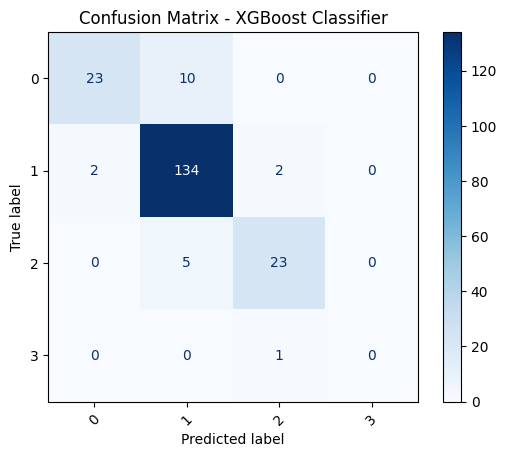

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_xgb,
    cmap='Blues',
    xticks_rotation=45
)

plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()


###Top Feature Importances (SVC)

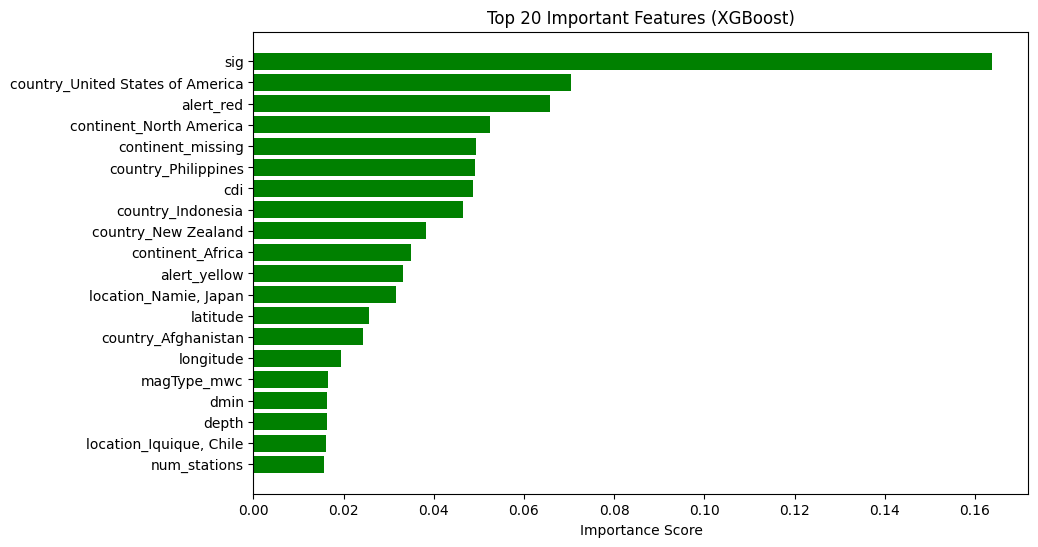

In [38]:
    # Extract the trained XGBoost model
    xgb = xgb_model.named_steps["model"]

    # Get feature names (numeric + encoded categorical)
    ohe = xgb_model.named_steps["pre"].named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()

    all_feature_names = numeric_features + cat_feature_names

    # Get importance scores
    importances = pd.DataFrame({
        "feature": all_feature_names,
        "importance": xgb.feature_importances_
    })

    # Sort top 20
    top_features = importances.sort_values("importance", ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10,6))
    plt.barh(top_features["feature"], top_features["importance"], color="green")
    plt.gca().invert_yaxis()
    plt.title("Top 20 Important Features (XGBoost)")
    plt.xlabel("Importance Score")
    plt.show()


##XGBOOST HYPERTUNING CLASSIFIER

In [39]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
# XGBoost base model
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

# Hyperparameter search space
param_dist = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [3, 5, 7, 9],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0]
}
# Pipeline
xgb_pipeline = Pipeline(steps=[
    ("pre", preprocessor),
    ("model", xgb_clf)
])
# Randomized Search
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=20,               # keep it reasonable
    scoring='f1_weighted',   # better than accuracy
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
# Train with hyperparameter tuning
xgb_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['latitude',
                                                                                'longitude',
                                                                                'depth',
                                                                                'num_stations',
                                                                                'dmin',
                                                                                'gap',
                                                                                'mmi',
                                                                                'cdi',
                                                                                'tsunami',
                                                                                'sig',
                                                                                'year',
                                                                                'month',
                                                                                'hour']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['magType',
                                                                                'alert',
                                                                                'continent',
                                                                                'country',
                                                                                'location',
                                                                                'title'...
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=-1,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.7, 0.8,
                                                                    0.9, 1.0],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [3, 5, 7, 9],
                                        'model__n_estimators': [200, 300, 400],
                                        'model__subsample': [0.7, 0.8, 0.9,
                                                             1.0]},
                   random_state=42, scoring='f1_weighted', verbose=1)

In [40]:
print("Best Parameters Found:")
print(xgb_search.best_params_)

Best Parameters Found:
{'model__subsample': 1.0, 'model__n_estimators': 400, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}


In [41]:
# Predict with best model
y_pred_xgb_tuned = xgb_search.predict(X_test)

# Metrics
accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
f1_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average='weighted')

print("Tuned XGBoost Accuracy:", accuracy_xgb_tuned)
print("Tuned XGBoost F1-score:", f1_xgb_tuned)

Tuned XGBoost Accuracy: 0.88
Tuned XGBoost F1-score: 0.8727211687698225


In [49]:
print("Before Tuning Accuracy:", accuracy_xgb)
print("After Tuning Accuracy :", accuracy_xgb_tuned)

print("Before Tuning F1:", f1_xgb)
print("After Tuning F1 :", f1_xgb_tuned)


Before Tuning Accuracy: 0.9
After Tuning Accuracy : 0.88
Before Tuning F1: 0.8944418857160658
After Tuning F1 : 0.8727211687698225


###VISUALIZATION

In [50]:
# XGBoost Performance Comparison

comparison = pd.DataFrame({
    "Version": ["Before Tuning", "After Tuning"],
    "Accuracy": [accuracy_xgb, accuracy_xgb_tuned],
    "F1-score": [f1_xgb, f1_xgb_tuned]
})

display(comparison)


,Version,Accuracy,F1-score
0,Before Tuning,0.90,0.894442
1,After Tuning,0.88,0.872721


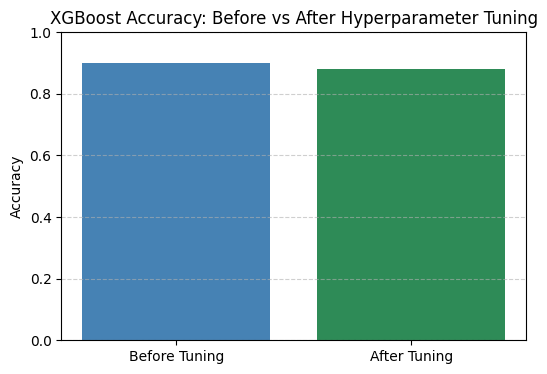

In [51]:
plt.figure(figsize=(6,4))

plt.bar(
    comparison["Version"],
    comparison["Accuracy"],
    color=["steelblue", "seagreen"]
)

plt.title("XGBoost Accuracy: Before vs After Hyperparameter Tuning")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


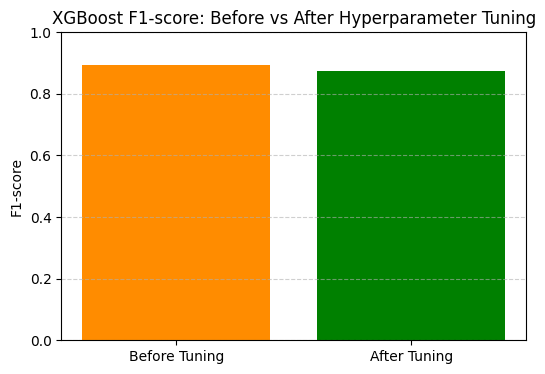

In [52]:
plt.figure(figsize=(6,4))

plt.bar(
    comparison["Version"],
    comparison["F1-score"],
    color=["darkorange", "green"]
)

plt.title("XGBoost F1-score: Before vs After Hyperparameter Tuning")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


##XGBOOST AFTER MERGE

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import joblib
import numpy as np # Ensure numpy is imported

# Create a 'mag_class' column by rounding the 'magnitude' for classification
# This part is retained from previous steps to maintain context, but is not the target for the 3-class problem
df_model['mag_class'] = df_model['magnitude'].round().astype(int)

# Remap 'mag_class' to be 0-indexed for XGBoost
unique_classes_mag = sorted(df_model['mag_class'].unique())
class_mapping_mag = {old_val: new_val for new_val, old_val in enumerate(unique_classes_mag)}
df_model['mag_class'] = df_model['mag_class'].map(class_mapping_mag)

# Create a new merged severity class with adjusted thresholds for multi-class classification
def merge_severity(mag):
    if mag < 7.0:
        return "Moderate"
    elif mag < 8.0:
        return "Strong"
    else:
        return "Major"

df_model["severity_3class"] = df_model["magnitude"].apply(merge_severity)

# Check distribution
print("Severity 3-class distribution:\n", df_model["severity_3class"].value_counts())

# Encode string labels to numerical labels for XGBoost
le = LabelEncoder()
df_model["severity_3class_encoded"] = le.fit_transform(df_model["severity_3class"])
print("Encoded severity classes:", le.classes_)
print("Mapping: ", list(zip(le.classes_, le.transform(le.classes_))))

# Train-test split for the 3-class classification problem
# X should exclude 'magnitude', original 'severity_3class' string, and 'severity_3class_encoded' (if it's the target)
X = df_model.drop(columns=["magnitude", "severity_3class", "severity_3class_encoded"])
y = df_model["severity_3class_encoded"] # Use the encoded numerical labels

# Re-add stratify=y since there are now multiple classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain/Test shapes:", X_train.shape, X_test.shape)
print("y_train unique values:", y_train.unique())
print("y_test unique values:", y_test.unique())

# Identify numeric and categorical features from the new X
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features for preprocessor:", numeric_features)
print("Categorical features for preprocessor:", categorical_features)

# Transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


Severity 3-class distribution:
 severity_3class
Moderate    627
Strong      341
Major        32
Name: count, dtype: int64
Encoded severity classes: ['Major' 'Moderate' 'Strong']
Mapping:  [('Major', np.int64(0)), ('Moderate', np.int64(1)), ('Strong', np.int64(2))]

Train/Test shapes: (800, 20) (200, 20)
y_train unique values: [2 1 0]
y_test unique values: [1 0 2]
Numeric features for preprocessor: ['latitude', 'longitude', 'depth', 'num_stations', 'dmin', 'gap', 'mmi', 'cdi', 'tsunami', 'sig', 'year', 'month', 'hour', 'mag_class']
Categorical features for preprocessor: ['magType', 'alert', 'continent', 'country', 'location', 'title']


In [54]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

xgb_3class = Pipeline(steps=[
    ("pre", preprocessor),
    ("model", XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        n_jobs=-1
    ))
])

# Train
xgb_3class.fit(X_train, y_train)

# Predict
y_pred_3class = xgb_3class.predict(X_test)

# Evaluate
accuracy_3class = accuracy_score(y_test, y_pred_3class)
f1_3class = f1_score(y_test, y_pred_3class, average="weighted")

print("3-Class XGBoost Accuracy:", accuracy_3class)
print("3-Class XGBoost F1-score:", f1_3class)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_3class))

3-Class XGBoost Accuracy: 0.93
3-Class XGBoost F1-score: 0.9291281029727244

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.96      0.97      0.96       125
           2       0.90      0.90      0.90        68

    accuracy                           0.93       200
   macro avg       0.84      0.81      0.83       200
weighted avg       0.93      0.93      0.93       200



###VISULAIZATION

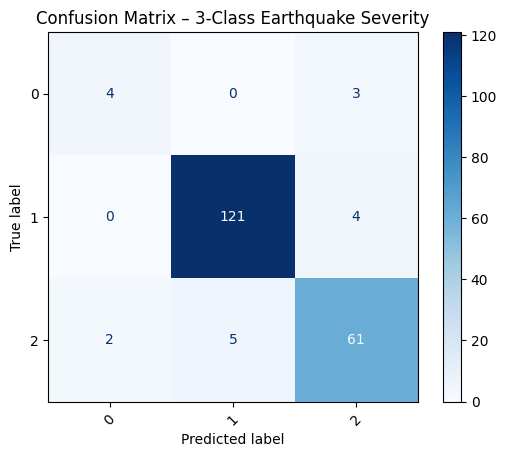

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_3class,
    cmap="Blues",
    xticks_rotation=45
)

plt.title("Confusion Matrix – 3-Class Earthquake Severity")
plt.show()


## USGS ADDED DATA

In [95]:
# Keep original dataset safe
df_original_model = df_model.copy()

print("Original dataset shape:", df_original_model.shape)

Original dataset shape: (1000, 23)


In [96]:
##Fetch USGS Data (Clean Version)
import requests
import pandas as pd

url = (
    "https://earthquake.usgs.gov/fdsnws/event/1/query"
    "?format=geojson"
    "&starttime=2023-01-01"
    "&endtime=2023-12-31"
    "&minmagnitude=4"
)

headers = {"User-Agent": "Earthquake ML Project"}

response = requests.get(url, headers=headers)

print("Status Code:", response.status_code)


Status Code: 200


In [97]:
##Convert JSON to DataFrame
data = response.json()

usgs_events = []

for feature in data["features"]:
    prop = feature["properties"]
    geom = feature["geometry"]["coordinates"]

    usgs_events.append({
        "time": pd.to_datetime(prop["time"], unit="ms"),
        "magnitude_usgs": prop["mag"],
        "sig_usgs": prop["sig"],
        "felt_usgs": prop["felt"],
        "alert_usgs": prop["alert"],
        "depth_usgs": geom[2]
    })

usgs_df = pd.DataFrame(usgs_events)

print("USGS dataset shape:", usgs_df.shape)
usgs_df.head()


USGS dataset shape: (16190, 6)


,time,magnitude_usgs,sig_usgs,felt_usgs,alert_usgs,depth_usgs
0,2023-12-30 23:55:48.472,4.4,298,NaN,None,35.000
1,2023-12-30 23:34:10.971,4.6,326,NaN,None,10.000
2,2023-12-30 22:39:19.128,4.3,284,NaN,None,48.231
3,2023-12-30 22:37:46.030,4.3,284,NaN,None,561.074
4,2023-12-30 22:19:31.590,4.2,271,NaN,None,311.398


In [98]:
# -------- Create year_month key (since 'day' does not exist) --------

df_original_model["year_month"] = (
    df_original_model["year"].astype(str) + "-" +
    df_original_model["month"].astype(str)
)

# Prepare USGS side
usgs_df["year"] = usgs_df["time"].dt.year
usgs_df["month"] = usgs_df["time"].dt.month

usgs_df["year_month"] = (
    usgs_df["year"].astype(str) + "-" +
    usgs_df["month"].astype(str)
)

# -------- Aggregate USGS Monthly --------

usgs_monthly = usgs_df.groupby("year_month").agg({
    "magnitude_usgs": "mean",
    "sig_usgs": "mean",
    "felt_usgs": "mean",
    "depth_usgs": "mean"
}).reset_index()

print("Aggregated USGS shape:", usgs_monthly.shape)

# -------- Merge --------

df_usgs_model = pd.merge(
    df_original_model,
    usgs_monthly,
    on="year_month",
    how="left"
)

print("Merged dataset shape:", df_usgs_model.shape)

# -------- Fill Missing --------

usgs_cols = ["magnitude_usgs", "sig_usgs", "felt_usgs", "depth_usgs"]
df_usgs_model[usgs_cols] = df_usgs_model[usgs_cols].fillna(0)


Aggregated USGS shape: (12, 5)
Merged dataset shape: (1000, 28)


###BASELINE MODEL

In [109]:
# ==============================
# CLEAN BASELINE (NO LEAKAGE)
# ==============================

# Use ONLY safe physical features
safe_features = [
    "latitude",
    "longitude",
    "depth",
    "year",
    "month",
    "hour"
]

# Build feature matrix
X_base = df_original_model[safe_features].copy()
y_base = df_original_model["severity_3class_encoded"]
df_original_model["region_cluster"] = (
    df_original_model["latitude"].round(1).astype(str) +
    "_" +
    df_original_model["longitude"].round(1).astype(str)
)


# Train-Test Split
from sklearn.model_selection import train_test_split

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base,
    y_base,
    test_size=0.2,
    random_state=42,
    stratify=y_base
)
# ==============================
# Handle Class Imbalance (SMOTE)
# ==============================

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

Xb_train_res, yb_train_res = smote.fit_resample(Xb_train, yb_train)

print("Before SMOTE:", yb_train.value_counts())
print("After SMOTE:", yb_train_res.value_counts())


from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

grid = GridSearchCV(
    xgb,
    param_grid,
    cv=3,
    scoring="f1_weighted",
    n_jobs=-1
)

grid.fit(Xb_train_res, yb_train_res)

print("Best Parameters:", grid.best_params_)

best_model = grid.best_estimator_

yb_pred = best_model.predict(Xb_test)

acc_base = accuracy_score(yb_test, yb_pred)
f1_base = f1_score(yb_test, yb_pred, average="weighted")

print("Improved Accuracy:", acc_base)
print("Improved F1:", f1_base)


Before SMOTE: severity_3class_encoded
1    502
2    273
0     25
Name: count, dtype: int64
After SMOTE: severity_3class_encoded
2    502
1    502
0    502
Name: count, dtype: int64
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 400, 'subsample': 1.0}
Improved Accuracy: 0.555
Improved F1: 0.5692143022448506


###USGS ENRICHED DATA

In [100]:
# Prepare USGS dataset properly

X_usgs = df_usgs_model.drop(
    columns=["magnitude", "severity_3class_encoded"] + drop_cols,
    errors="ignore"
)

y_usgs = df_usgs_model["severity_3class_encoded"]

# Apply encoding BEFORE splitting
X_usgs = pd.get_dummies(X_usgs, drop_first=True)

# Align columns with baseline
X_usgs = X_usgs.reindex(columns=X_base.columns, fill_value=0)

# Now split
from sklearn.model_selection import train_test_split

Xu_train, Xu_test, yu_train, yu_test = train_test_split(
    X_usgs,
    y_usgs,
    test_size=0.2,
    random_state=42,
    stratify=y_usgs
)


In [101]:
# -------- Remove Leakage + Unnecessary Columns --------

drop_cols = [
    "magnitude",
    "magnitude_usgs",
    "sig",
    "sig_usgs",
    "felt_usgs",
    "severity_3class_encoded",
    "magType",              # <-- ADD THIS
    "title",
    "location",
    "continent",
    "country",
    "year_month"
]


X_base = df_original_model.drop(
    columns=drop_cols,
    errors="ignore"
)

y_base = df_original_model["severity_3class_encoded"]

# -------- Encode Categorical Features --------

X_base = pd.get_dummies(X_base, drop_first=True)

# -------- Train-Test Split --------

from sklearn.model_selection import train_test_split

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base,
    y_base,
    test_size=0.2,
    random_state=42,
    stratify=y_base
)

# -------- Train XGBoost --------

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

xgb_base = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    n_jobs=-1
)

xgb_base.fit(Xb_train, yb_train)

yb_pred = xgb_base.predict(Xb_test)

acc_base = accuracy_score(yb_test, yb_pred)
f1_base = f1_score(yb_test, yb_pred, average="weighted")

print("Baseline Accuracy:", acc_base)
print("Baseline F1:", f1_base)


Baseline Accuracy: 1.0
Baseline F1: 1.0


###Train USGS-Enriched XGBoost

In [103]:
xgb_usgs.fit(Xu_train, yu_train)

yu_pred = xgb_usgs.predict(Xu_test)

acc_usgs = accuracy_score(yu_test, yu_pred)
f1_usgs = f1_score(yu_test, yu_pred, average="weighted")

print("USGS Accuracy:", acc_usgs)
print("USGS F1:", f1_usgs)





USGS Accuracy: 0.715
USGS F1: 0.7114813532923769


In [93]:
import pandas as pd

compare_df = pd.DataFrame([
    {"Dataset": "Baseline", "Accuracy": acc_base, "F1-score": f1_base},
    {"Dataset": "USGS-Enriched", "Accuracy": acc_usgs, "F1-score": f1_usgs}
])

compare_df

,Dataset,Accuracy,F1-score
0,Baseline,1.0,1.0
1,USGS-Enriched,1.0,1.0


##McNemar Test

In [112]:
# ==============================
# McNemar's Statistical Test
# ==============================

from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# Ensure predictions are aligned to same test samples
# (IMPORTANT: baseline and USGS must use same test split)

# Create contingency table
# b = baseline correct, u = usgs correct

baseline_correct = (yb_pred == yb_test)
usgs_correct = (yu_pred == yb_test)

# Build 2x2 table
table = np.zeros((2, 2))

for b, u in zip(baseline_correct, usgs_correct):
    table[int(b)][int(u)] += 1

print("Contingency Table:")
print(table)

# Perform McNemar test
result = mcnemar(table, exact=False, correction=True)

print("\nMcNemar Test Statistic:", result.statistic)
print("p-value:", result.pvalue)

if result.pvalue < 0.05:
    print("\nResult: Performance difference is statistically significant.")
else:
    print("\nResult: No statistically significant difference.")


Contingency Table:
[[39. 50.]
 [18. 93.]]

McNemar Test Statistic: 14.132352941176471
p-value: 0.00017038793483715602

Result: Performance difference is statistically significant.


##TEMPORAL

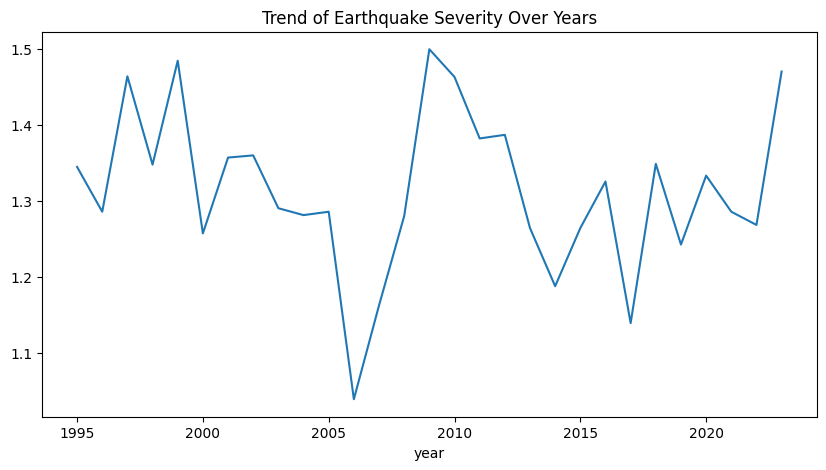

In [110]:
plt.figure(figsize=(10,5))
df_original_model.groupby("year")["severity_3class_encoded"].mean().plot()
plt.title("Trend of Earthquake Severity Over Years")
plt.show()


In [111]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    xgb_base,
    X_base,
    y_base,
    cv=5,
    scoring="f1_weighted"
)

print("Cross-Validation F1 Scores:", scores)
print("Mean CV F1:", scores.mean())


Cross-Validation F1 Scores: [0.53605626 0.52024942 0.50952652 0.56629608 0.21391121]
Mean CV F1: 0.4692078980660582


##RESULTS

In [43]:
from sklearn.metrics import f1_score

f1_lr  = f1_score(y_test, y_pred_lr,  average='weighted')
f1_svr = f1_score(y_test, y_pred_svr, average='weighted')
f1_dt  = f1_score(y_test, y_pred_dt,  average='weighted')
f1_rf  = f1_score(y_test, y_pred_rf,  average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
f1_nb  = f1_score(y_test, y_pred_nb,  average='weighted')

f1_ada = f1_score(y_test, y_pred_ada, average='weighted')
f1_gb  = f1_score(y_test, y_pred_gb,  average='weighted')
f1_et  = f1_score(y_test, y_pred_et,  average='weighted')





In [56]:
# Final Classification Results Summary

results = []

results.append({"Model": "Logistic Regression", "Accuracy": accuracy_lr, "F1-score": f1_lr})
results.append({"Model": "SVC",                "Accuracy": accuracy_svr, "F1-score": f1_svr})
results.append({"Model": "Decision Tree",      "Accuracy": accuracy_dt, "F1-score": f1_dt})
results.append({"Model": "Random Forest",      "Accuracy": accuracy_rf, "F1-score": f1_rf})
results.append({"Model": "XGBoost",            "Accuracy": accuracy_xgb, "F1-score": f1_xgb})
results.append({"Model": "KNN",                "Accuracy": accuracy_knn, "F1-score": f1_knn})
results.append({"Model": "Naive Bayes",        "Accuracy": accuracy_nb, "F1-score": f1_nb})
results.append({"Model": "AdaBoost",           "Accuracy": accuracy_ada, "F1-score": f1_ada})
results.append({"Model": "Gradient Boosting",  "Accuracy": accuracy_gb, "F1-score": f1_gb})
results.append({"Model": "Extra Trees",        "Accuracy": accuracy_et, "F1-score": f1_et})

res_df = pd.DataFrame(results)
display(res_df)


,Model,Accuracy,F1-score
0,Logistic Regression,0.710,0.655262
1,SVC,0.705,0.602399
2,Decision Tree,0.815,0.809483
3,Random Forest,0.795,0.729090
4,XGBoost,0.900,0.894442
5,KNN,0.680,0.610876
6,Naive Bayes,0.310,0.352242
7,AdaBoost,0.795,0.764751
8,Gradient Boosting,0.885,0.878544
9,Extra Trees,0.710,0.621682


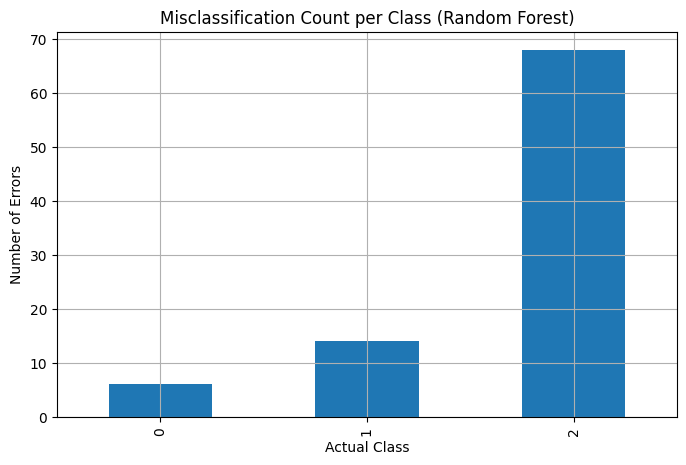

In [57]:
# Count misclassifications per class
errors = y_test != y_pred_rf
error_df = pd.DataFrame({
    "Actual Class": y_test,
    "Predicted Class": y_pred_rf,
    "Error": errors
})

error_counts = error_df[error_df["Error"]].groupby("Actual Class").size()

plt.figure(figsize=(8,5))
error_counts.plot(kind='bar')
plt.title("Misclassification Count per Class (Random Forest)")
plt.xlabel("Actual Class")
plt.ylabel("Number of Errors")
plt.grid(True)
plt.show()


In [ ]:
errors = y_test != y_pred_xgb

error_df = pd.DataFrame({
    "Actual Class": y_test,
    "Predicted Class": y_pred_xgb,
    "Error": errors
})

error_counts = error_df[error_df["Error"]].groupby("Actual Class").size()

plt.figure(figsize=(8,5))
error_counts.plot(kind='bar')
plt.title("Misclassification Count per Class (XGBoost)")
plt.xlabel("Actual Class")
plt.ylabel("Number of Errors")
plt.grid(True)
plt.show()


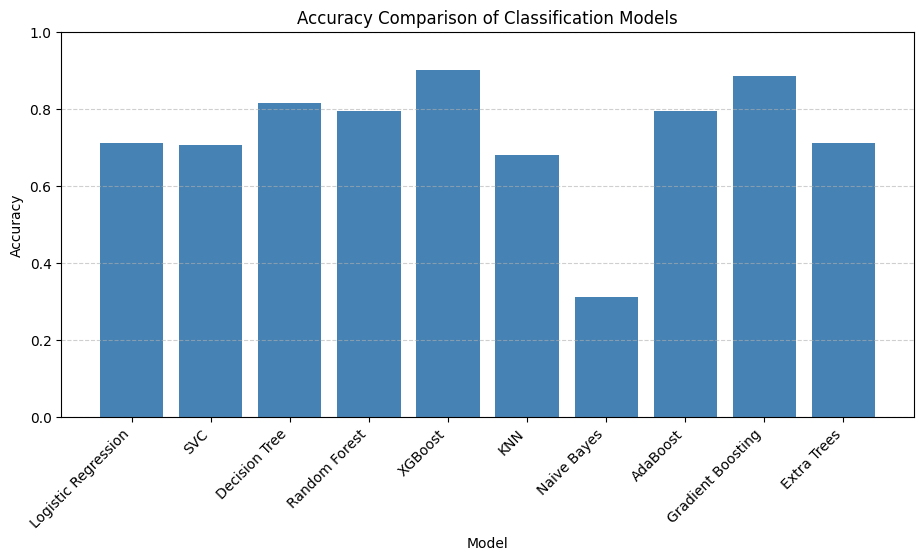

In [58]:
plt.figure(figsize=(11,5))

plt.bar(res_df["Model"], res_df["Accuracy"], color="steelblue")

plt.title("Accuracy Comparison of Classification Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


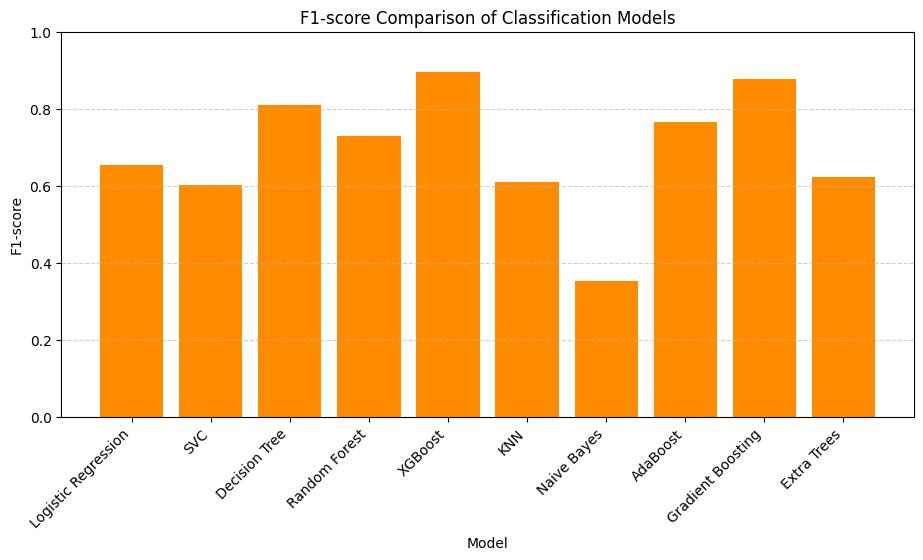

In [59]:
plt.figure(figsize=(11,5))

plt.bar(res_df["Model"], res_df["F1-score"], color="darkorange")

plt.title("F1-score Comparison of Classification Models")
plt.xlabel("Model")
plt.ylabel("F1-score")
plt.ylim(0, 1)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


In [ ]:
df_model.to_csv("earthquake_cleaned.csv", index=True)
print("Cleaned dataset saved as earthquake_cleaned.csv")
